In [1]:
# Import standard libraries
import warnings
warnings.filterwarnings("ignore")
from importlib import reload
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss  
import csv
import pandas as pd
import networkx as nx
import pickle
import itertools
import os.path
import math
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from collections import defaultdict
import time
from tqdm import tqdm
import random
import cooltools
import cooler
import fanc
import matplotlib.pyplot as plt
import fanc.plotting as fancplot

# Style
sns.set_style("whitegrid", {'axes.grid' : False})

# Directories

In [2]:
# Directories
data_cool_dir = './data/hic_data_cool/'
data_hic_dir = './data/hic_data_juicer/'

# Load data

In [3]:
# Load data at 250kb
resol = '250kb'
norm = 'SCALE'

hic_250kb_old1 = fanc.load(data_hic_dir+f"trimmed_Old_B1R1_dedup_filter.dedup.pairs.hic@{resol}@{norm}")
hic_250kb_old2 = fanc.load(data_hic_dir+f"trimmed_Old_B2R2_dedup_filter.dedup.pairs.hic@{resol}@{norm}")
hic_250kb_young1 = fanc.load(data_hic_dir+f"trimmed_Young_B1R1_dedup_filter.dedup.pairs.hic@{resol}@{norm}")
hic_250kb_young2 = fanc.load(data_hic_dir+f"trimmed_Young_B1R2_dedup_filter.dedup.pairs.hic@{resol}@{norm}")

In [4]:
# Load data at 1Mb
resol = '100kb'
norm = 'SCALE'

hic_100kb_old1 = fanc.load(data_hic_dir+f"trimmed_Old_B1R1_dedup_filter.dedup.pairs.hic@{resol}@{norm}")
hic_100kb_old2 = fanc.load(data_hic_dir+f"trimmed_Old_B2R2_dedup_filter.dedup.pairs.hic@{resol}@{norm}")
hic_100kb_young1 = fanc.load(data_hic_dir+f"trimmed_Young_B1R1_dedup_filter.dedup.pairs.hic@{resol}@{norm}")
hic_100kb_young2 = fanc.load(data_hic_dir+f"trimmed_Young_B1R2_dedup_filter.dedup.pairs.hic@{resol}@{norm}")

# Distance decay plots

We generate distance decay plots of both young Hi-C replicates and both old Hi-C replicates for each chromosome. In these plots, the rate of decay of contacts with genomic separation reflects the polymeric nature of chromosomes and hint at the global folding patterns of the genome. We observe similar decay rates for all replicates across all chromosomes, suggesting no substantial intrachromosomal folding differences between the young and the old cell states. We will indeed see later in our paper that age-associated chromatin packing differences are mostly found at the interchromosomal level.

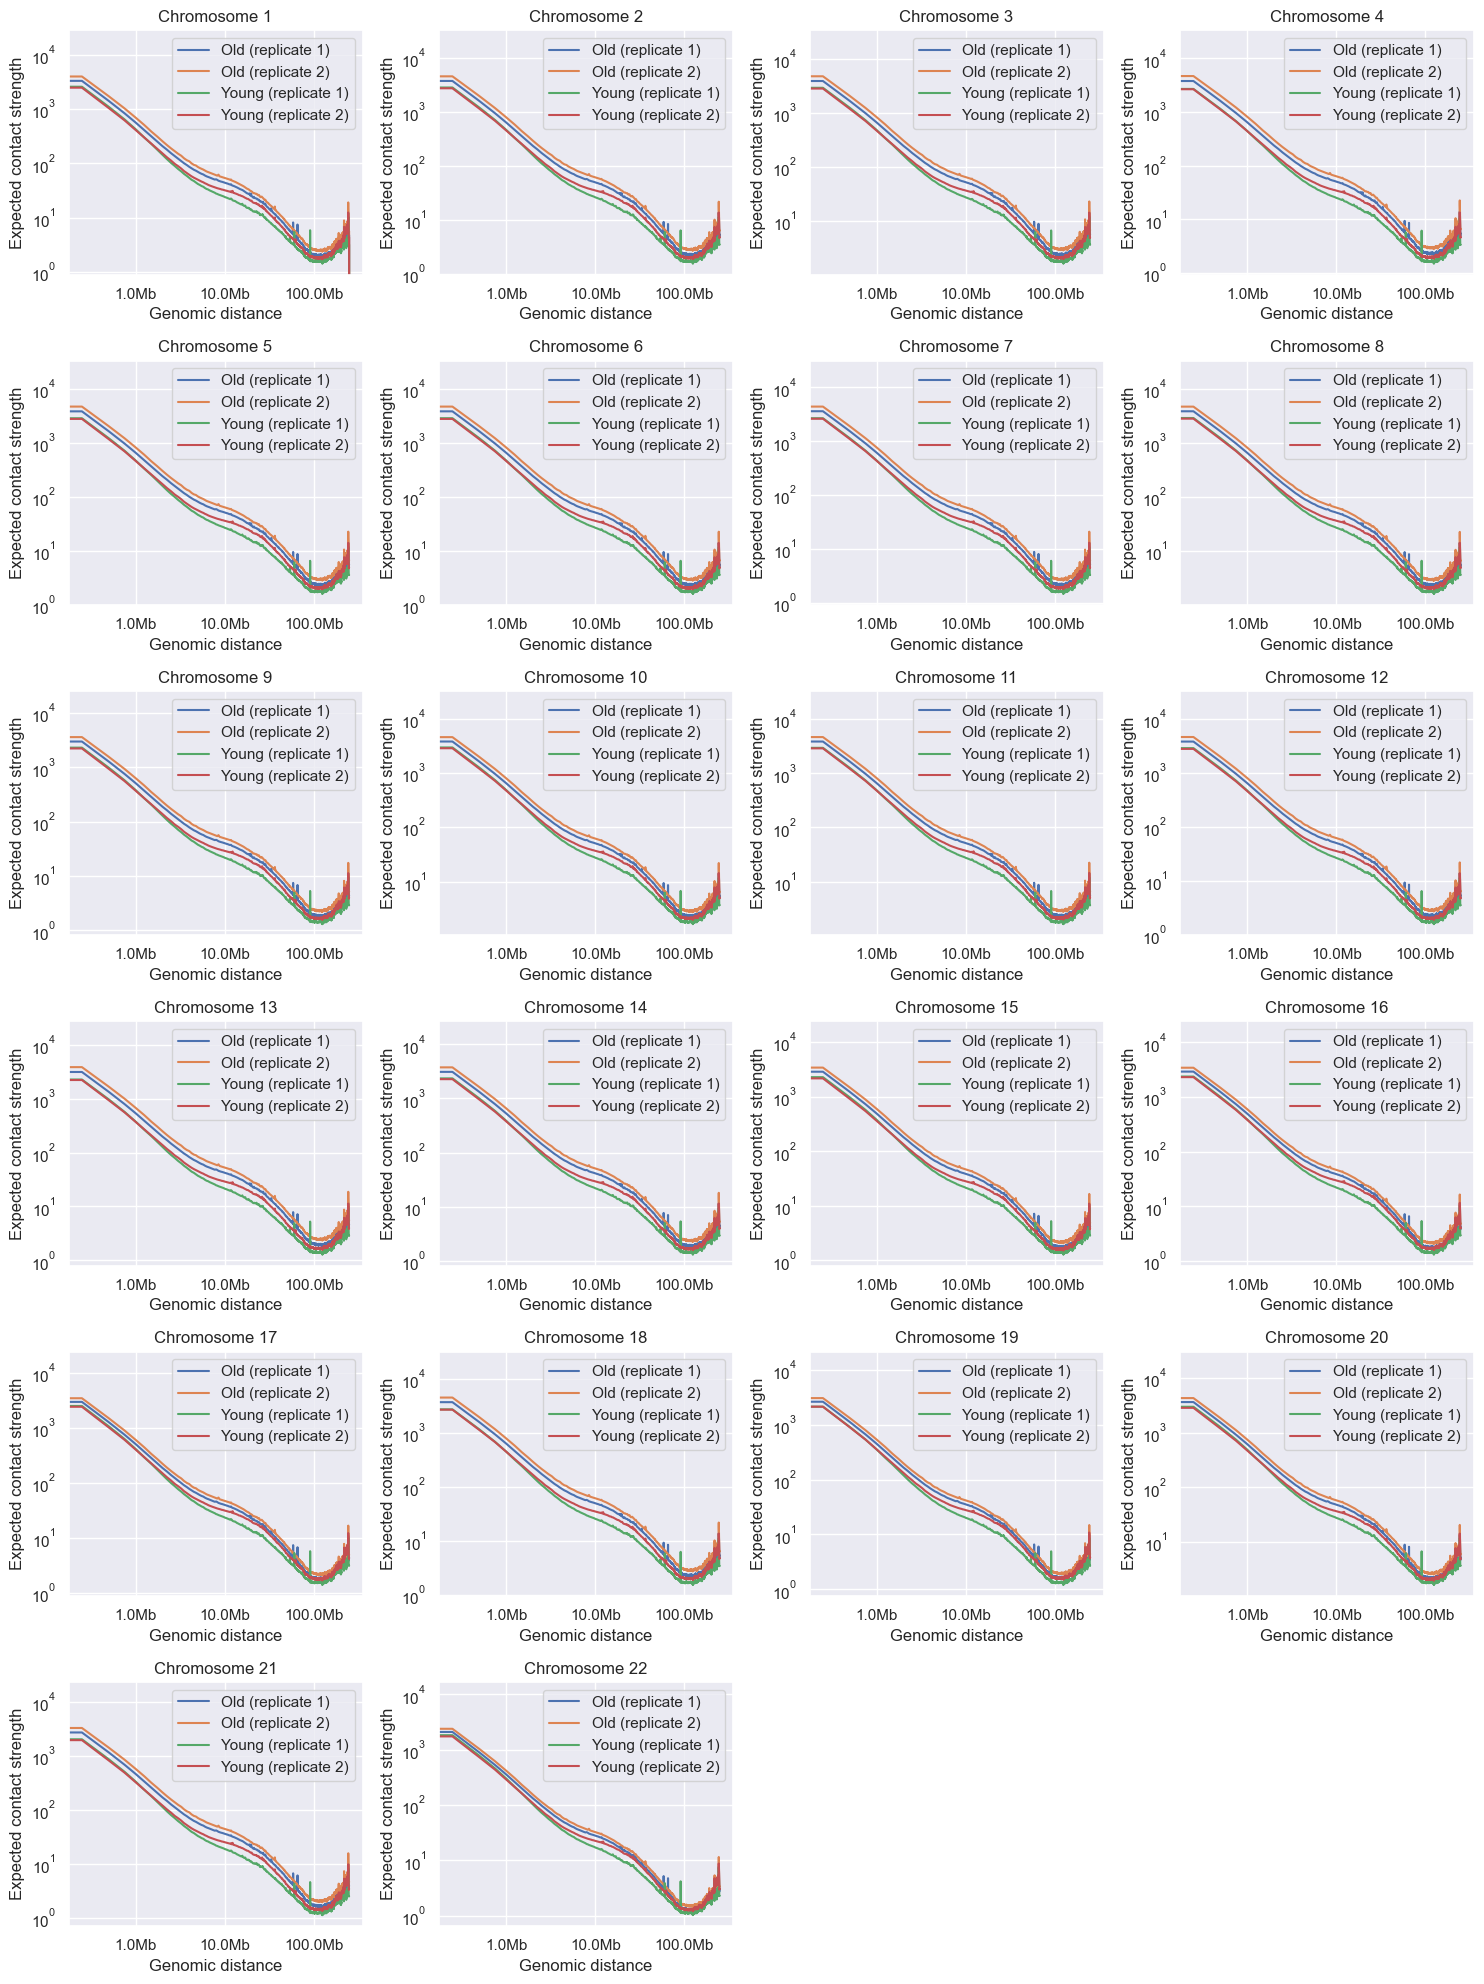

In [5]:
# Distance decay plots
sns.set(font_scale=1)
chrom_list = [str(i) for i in np.arange(1, 22+1)]
nrows, ncols = 6, 4  # Define the number of rows and columns in the grid
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 20))  # You can adjust the figure size as needed

for i, chrom in enumerate(chrom_list):
    row = i // ncols
    col = i % ncols
    ax = axes[row, col]
    
    fancplot.distance_decay_plot(
        hic_250kb_old1, hic_250kb_old2, hic_250kb_young1, hic_250kb_young2, 
        chromosome=chrom, 
        labels=['Old (replicate 1)', 'Old (replicate 2)', 'Young (replicate 1)', 'Young (replicate 2)'],
        norm=True,
        ax=ax
    )
    
    ax.set_title(f'Chromosome {chrom}')
    ax.legend(loc='upper right')

# Hide any empty subplots (if there are fewer than 22 plots)
for i in range(len(chrom_list), nrows * ncols):
    row = i // ncols
    col = i % ncols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# Insulation score and boundary calls

Describe takeaway

In [6]:
# Compute insulation scores
window_size = 1000000
insulation_old1 = fanc.InsulationScores.from_hic(
    hic=hic_100kb_old1,
    window_sizes=[window_size],
    file_name=data_hic_dir+"domains/hic_100kb_old1.insulation"
)
insulation_old2 = fanc.InsulationScores.from_hic(
    hic=hic_100kb_old2,
    window_sizes=[window_size],
    file_name=data_hic_dir+"domains/hic_100kb_old2.insulation"
)
insulation_young1 = fanc.InsulationScores.from_hic(
    hic=hic_100kb_young1,
    window_sizes=[window_size],
    file_name=data_hic_dir+"domains/hic_100kb_young1.insulation"
)
insulation_young2 = fanc.InsulationScores.from_hic(
    hic=hic_100kb_young2,
    window_sizes=[window_size],
    file_name=data_hic_dir+"domains/hic_100kb_young2.insulation"
)

INFO:fanc.architecture.domains:1 (1/24)
INFO:fanc.architecture.domains:2 (2/24)
INFO:fanc.architecture.domains:3 (3/24)
INFO:fanc.architecture.domains:4 (4/24)
INFO:fanc.architecture.domains:5 (5/24)
INFO:fanc.architecture.domains:6 (6/24)
INFO:fanc.architecture.domains:7 (7/24)
INFO:fanc.architecture.domains:8 (8/24)
INFO:fanc.architecture.domains:9 (9/24)
INFO:fanc.architecture.domains:10 (10/24)
INFO:fanc.architecture.domains:11 (11/24)
INFO:fanc.architecture.domains:12 (12/24)
INFO:fanc.architecture.domains:13 (13/24)
INFO:fanc.architecture.domains:14 (14/24)
INFO:fanc.architecture.domains:15 (15/24)
INFO:fanc.architecture.domains:16 (16/24)
INFO:fanc.architecture.domains:17 (17/24)
INFO:fanc.architecture.domains:18 (18/24)
INFO:fanc.architecture.domains:19 (19/24)
INFO:fanc.architecture.domains:20 (20/24)
INFO:fanc.architecture.domains:21 (21/24)
INFO:fanc.architecture.domains:22 (22/24)
INFO:fanc.architecture.domains:X (23/24)
INFO:fanc.architecture.domains:Y (24/24)
INFO:fanc.ar

In [7]:
# Retrieve insulation scores for all chromosomes
chrom_list = [str(i) for i in np.arange(1, 22+1)]

scores_old1 = defaultdict(dict)
for chrom in chrom_list:
    for region in insulation_old1.regions(chrom):
        score = region.insulation_1000000
        if np.isnan(score):
            score = 0
        scores_old1[chrom][str(region)] = float(score)
        
scores_old2 = defaultdict(dict)
for chrom in chrom_list:
    for region in insulation_old2.regions(chrom):
        score = region.insulation_1000000
        if np.isnan(score):
            score = 0
        scores_old2[chrom][str(region)] = score
        
scores_young1 = defaultdict(dict)
for chrom in chrom_list:
    for region in insulation_young1.regions(chrom):
        score = region.insulation_1000000
        if np.isnan(score):
            score = 0
        scores_young1[chrom][str(region)] = score
        
scores_young2 = defaultdict(dict)
for chrom in chrom_list:
    for region in insulation_young2.regions(chrom):
        score = region.insulation_1000000
        if np.isnan(score):
            score = 0
        scores_young2[chrom][str(region)] = score

In [8]:
# Compute boundary scores for all chromosomes

boundaries_old1 = fanc.Boundaries.from_insulation_score(insulation_old1, window_size=1000000)
boundary_regions_old1 = list([str(r) for r in boundaries_old1.regions()])
boundary_scores_old1 = list((boundaries_old1.scores()))
boundaries_old1_df = pd.DataFrame({'boundary': boundary_regions_old1, 'score': boundary_scores_old1})
boundaries_old1_df.loc[:, 'chrom'] = boundaries_old1_df['boundary'].str.split(':', expand=True)[0]

boundaries_old2 = fanc.Boundaries.from_insulation_score(insulation_old2, window_size=1000000)
boundary_regions_old2 = list([str(r) for r in boundaries_old2.regions()])
boundary_scores_old2 = list((boundaries_old2.scores()))
boundaries_old2_df = pd.DataFrame({'boundary': boundary_regions_old2, 'score': boundary_scores_old2})
boundaries_old2_df.loc[:, 'chrom'] = boundaries_old2_df['boundary'].str.split(':', expand=True)[0]

boundaries_young1 = fanc.Boundaries.from_insulation_score(insulation_young1, window_size=1000000)
boundary_regions_young1 = list([str(r) for r in boundaries_young1.regions()])
boundary_scores_young1 = list((boundaries_young1.scores()))
boundaries_young1_df = pd.DataFrame({'boundary': boundary_regions_young1, 'score': boundary_scores_young1})
boundaries_young1_df.loc[:, 'chrom'] = boundaries_young1_df['boundary'].str.split(':', expand=True)[0]

boundaries_young2 = fanc.Boundaries.from_insulation_score(insulation_young2, window_size=1000000)
boundary_regions_young2 = list([str(r) for r in boundaries_young2.regions()])
boundary_scores_young2 = list((boundaries_young2.scores()))
boundaries_young2_df = pd.DataFrame({'boundary': boundary_regions_young2, 'score': boundary_scores_young2})
boundaries_young2_df.loc[:, 'chrom'] = boundaries_young2_df['boundary'].str.split(':', expand=True)[0]

INFO:fanc.architecture.maxima_callers:Found 5384 raw peaks
INFO:fanc.architecture.domains:Found 2686 boundaries
INFO:fanc.architecture.maxima_callers:Found 5362 raw peaks
INFO:fanc.architecture.domains:Found 2680 boundaries
INFO:fanc.architecture.maxima_callers:Found 5397 raw peaks
INFO:fanc.architecture.domains:Found 2656 boundaries
INFO:fanc.architecture.maxima_callers:Found 5304 raw peaks
INFO:fanc.architecture.domains:Found 2646 boundaries


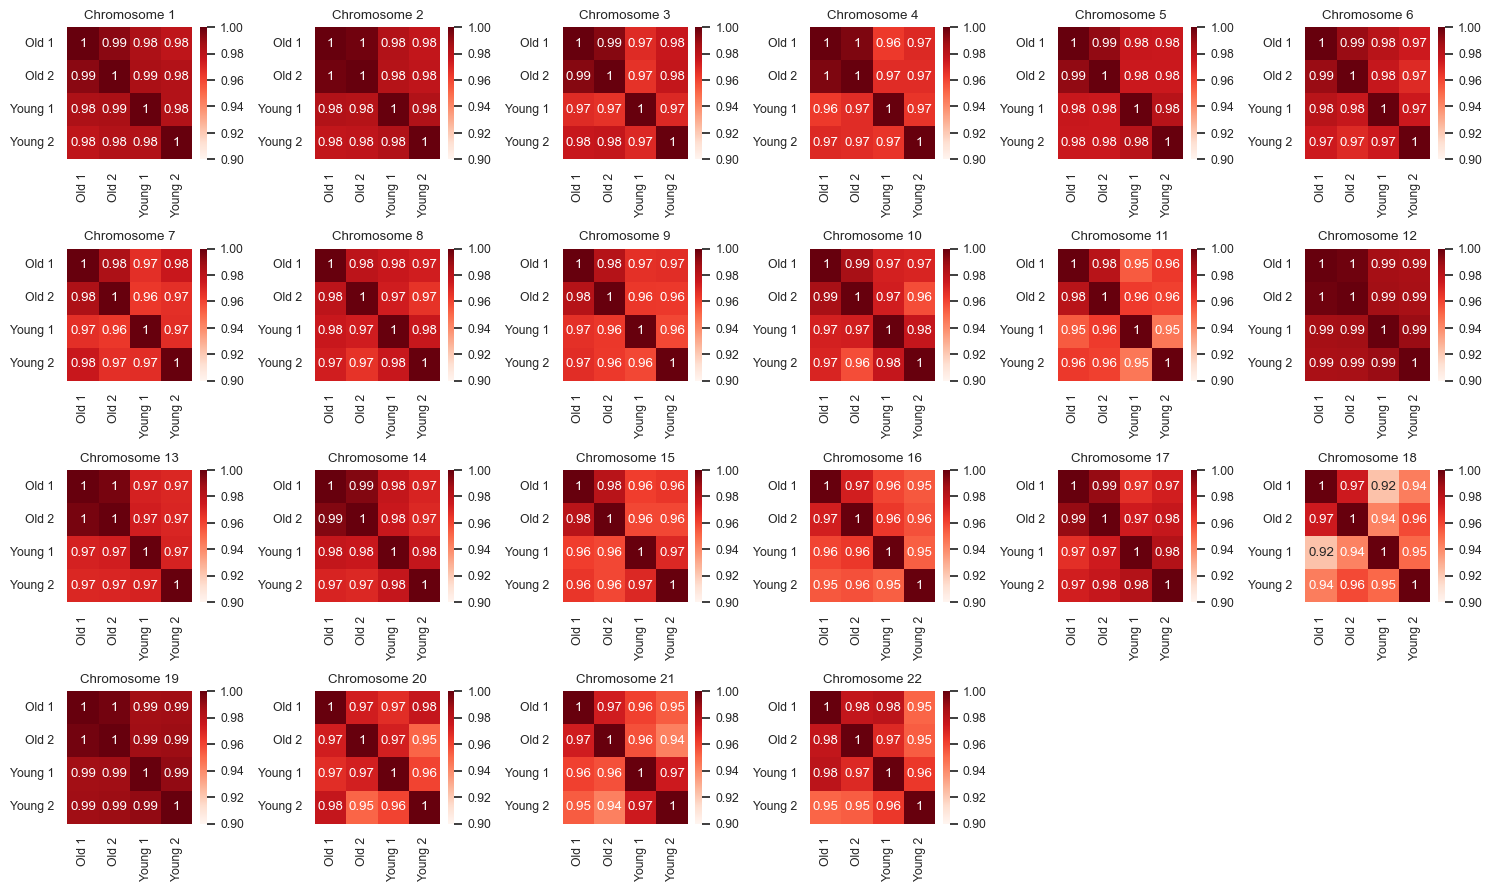

In [15]:
# Display correlation of insulation scores
sns.set(font_scale=0.8)
chrom_list = [str(i) for i in np.arange(1, 22+1)]
nrows, ncols = 4, 6  # Define the number of rows and columns in the grid
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 9))  # You can adjust the figure size as needed

for i, chrom in enumerate(chrom_list):
    
    # Insulation scores
    scores_old1_df = pd.DataFrame(scores_old1[chrom], index=['Old 1'])
    scores_old2_df = pd.DataFrame(scores_old2[chrom], index=['Old 2'])
    scores_young1_df = pd.DataFrame(scores_young1[chrom], index=['Young 1'])
    scores_young2_df = pd.DataFrame(scores_young2[chrom], index=['Young 2'])
    
    # Boundary calling
    df = boundaries_old1_df[boundaries_old1_df['chrom']==chrom][['boundary', 'score']]
    scores_old1_df_bound = pd.DataFrame(0, columns=scores_old1_df.columns, index=['Old 1 boundaries'])
    scores_old1_df_bound.loc['Old 1 boundaries', df['boundary'].values] = df['score'].values
    df = boundaries_old2_df[boundaries_old2_df['chrom']==chrom][['boundary', 'score']]
    scores_old2_df_bound = pd.DataFrame(0, columns=scores_old2_df.columns, index=['Old 2 boundaries'])
    scores_old2_df_bound.loc['Old 2 boundaries', df['boundary'].values] = df['score'].values
    df = boundaries_young1_df[boundaries_young1_df['chrom']==chrom][['boundary', 'score']]
    scores_young1_df_bound = pd.DataFrame(0, columns=scores_young1_df.columns, index=['Young 1 boundaries'])
    scores_young1_df_bound.loc['Young 1 boundaries', df['boundary'].values] = df['score'].values
    df = boundaries_young2_df[boundaries_young2_df['chrom']==chrom][['boundary', 'score']]
    scores_young2_df_bound = pd.DataFrame(0, columns=scores_young2_df.columns, index=['Young 2 boundaries'])
    scores_young2_df_bound.loc['Young 2 boundaries', df['boundary'].values] = df['score'].values
    
    scores_df = pd.concat(
        [
            scores_old1_df, scores_old1_df_bound,
            scores_old2_df, scores_old2_df_bound,
            scores_young1_df, scores_young1_df_bound,
            scores_young2_df, scores_young2_df_bound
        ],
        axis=0
    )
#     rows = ['Old 1 boundaries', 'Old 2 boundaries', 'Young 1 boundaries', 'Young 2 boundaries']
    rows = ['Old 1', 'Old 2', 'Young 1', 'Young 2']
    scores_corr_df = scores_df.loc[rows, :].T.corr(method='spearman')

    row = i // ncols
    col = i % ncols
    ax = axes[row, col]
    
    sns.heatmap(
        data=scores_corr_df,
        cmap='Reds',
        vmin=0.9,
        vmax=1,
        annot=True,
        ax=ax
    )
    ax.set_title(f'Chromosome {chrom}')

# Hide any empty subplots (if there are fewer than 22 plots)
for i in range(len(chrom_list), nrows * ncols):
    row = i // ncols
    col = i % ncols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

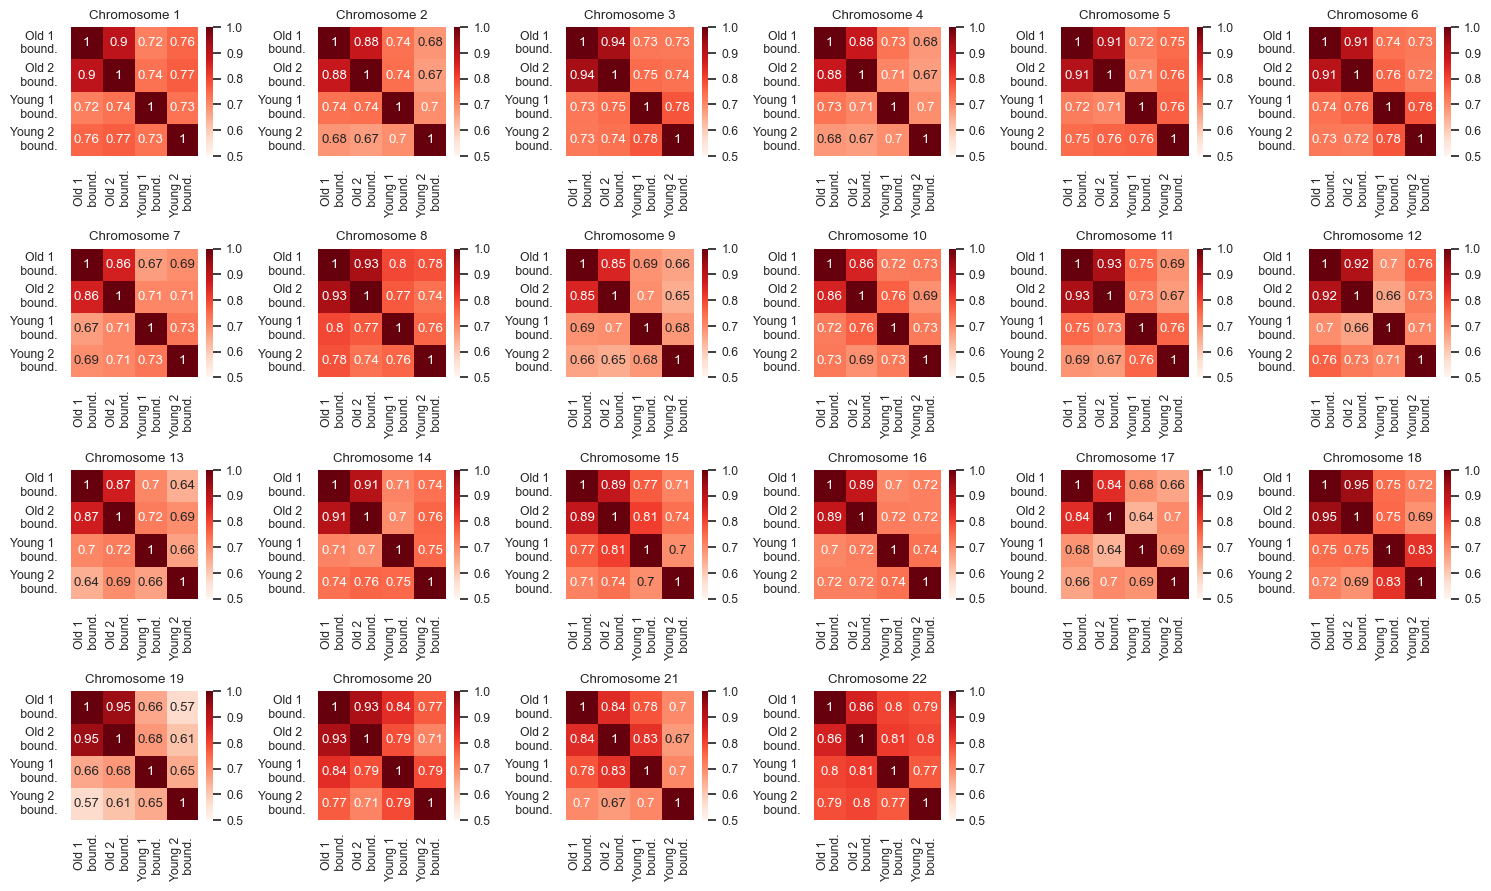

In [17]:
# Display correlation of insulation scores
sns.set(font_scale=0.8)
chrom_list = [str(i) for i in np.arange(1, 22+1)]
nrows, ncols = 4, 6  # Define the number of rows and columns in the grid
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 9))  # You can adjust the figure size as needed

for i, chrom in enumerate(chrom_list):
    
    # Insulation scores
    scores_old1_df = pd.DataFrame(scores_old1[chrom], index=['Old 1'])
    scores_old2_df = pd.DataFrame(scores_old2[chrom], index=['Old 2'])
    scores_young1_df = pd.DataFrame(scores_young1[chrom], index=['Young 1'])
    scores_young2_df = pd.DataFrame(scores_young2[chrom], index=['Young 2'])
    
    # Boundary calling
    df = boundaries_old1_df[boundaries_old1_df['chrom']==chrom][['boundary', 'score']]
    scores_old1_df_bound = pd.DataFrame(0, columns=scores_old1_df.columns, index=['Old 1 \n bound.'])
    scores_old1_df_bound.loc['Old 1 \n bound.', df['boundary'].values] = df['score'].values
    df = boundaries_old2_df[boundaries_old2_df['chrom']==chrom][['boundary', 'score']]
    scores_old2_df_bound = pd.DataFrame(0, columns=scores_old2_df.columns, index=['Old 2 \n bound.'])
    scores_old2_df_bound.loc['Old 2 \n bound.', df['boundary'].values] = df['score'].values
    df = boundaries_young1_df[boundaries_young1_df['chrom']==chrom][['boundary', 'score']]
    scores_young1_df_bound = pd.DataFrame(0, columns=scores_young1_df.columns, index=['Young 1 \n bound.'])
    scores_young1_df_bound.loc['Young 1 \n bound.', df['boundary'].values] = df['score'].values
    df = boundaries_young2_df[boundaries_young2_df['chrom']==chrom][['boundary', 'score']]
    scores_young2_df_bound = pd.DataFrame(0, columns=scores_young2_df.columns, index=['Young 2 \n bound.'])
    scores_young2_df_bound.loc['Young 2 \n bound.', df['boundary'].values] = df['score'].values
    
    scores_df = pd.concat(
        [
            scores_old1_df, scores_old1_df_bound,
            scores_old2_df, scores_old2_df_bound,
            scores_young1_df, scores_young1_df_bound,
            scores_young2_df, scores_young2_df_bound
        ],
        axis=0
    )
    rows = ['Old 1 \n bound.', 'Old 2 \n bound.', 'Young 1 \n bound.', 'Young 2 \n bound.']
#     rows = ['Old 1', 'Old 2', 'Young 1', 'Young 2']
    scores_corr_df = scores_df.loc[rows, :].T.corr(method='spearman')

    row = i // ncols
    col = i % ncols
    ax = axes[row, col]
    
    sns.heatmap(
        data=scores_corr_df,
        cmap='Reds',
        vmin=0.5,
        vmax=1,
        annot=True,
        ax=ax
    )
    ax.set_title(f'Chromosome {chrom}')

# Hide any empty subplots (if there are fewer than 22 plots)
for i in range(len(chrom_list), nrows * ncols):
    row = i // ncols
    col = i % ncols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

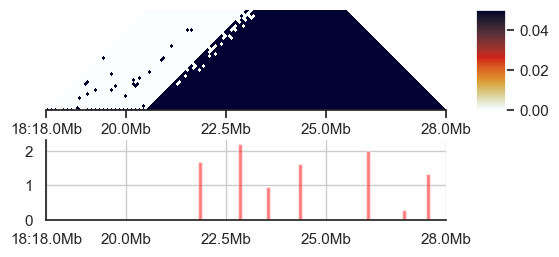

In [118]:
# Plot boundaries
ph = fancplot.TriangularMatrixPlot(hic_100kb_old1, max_dist=5000000, vmin=0, vmax=0.05)
pb = fancplot.BarPlot(boundaries_old1)
f = fancplot.GenomicFigure([ph, pb])
fig, axes = f.plot('18:18mb-28mb')